# Attribution Analysis for Splice Site Predictions

This notebook demonstrates how to compute and visualize input attributions (feature importance) for model predictions using gradient-based methods.

We compute gradients of the loss, so the signs indicate relative importance of input features for model decisions.

In [1]:
%matplotlib inline
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Setup path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from splicevo.io.gene_annotation import GTFProcessor
from splicevo.model import SplicevoModel
from splicevo.utils.data_utils import load_processed_data, load_predictions
from splicevo.utils.model_utils import load_model_and_config
from splicevo.attributions.compute import compute_attributions_splice, compute_attributions_usage, save_attributions_for_modisco
from splicevo.attributions.plot import plot_attributions_splice_from_result, plot_attributions_usage_from_result

# Setup device and reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
PyTorch version: 2.8.0
NumPy version: 2.2.6


In [2]:
# Configuration
species = "mouse_rat_human"
kb="1"
checkpoint_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/models/transformer_old/full_{species}_{kb}kb/best_model.pt"  
data_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_full_{kb}kb/{species}/test/"
predictions_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/predictions/transformer_old/full_{species}_{kb}kb/"
output_path=f"/home/elek/sds/sd17d003/Anamaria/splicevo/attributions/transformer_old/{species}_{kb}kb_examples/"
device = 'cuda'

# Load model
model, model_config = load_model_and_config(checkpoint_path, device=device)

# Load data (7 return values: sequences, labels, alpha, beta, sse, species_ids, condition_mask)
sequences, labels, _, _, usage, _, _ = load_processed_data(data_path, verbose=False)
metadata = pd.read_csv(data_path + "metadata.csv")

# Load splice predictions
pred_preds, pred_probs, pred_sse, meta, _, _ = load_predictions(predictions_path, verbose=False)

# Get condition names
with open(predictions_path + "metadata.json", 'r') as f:
    import json
    meta_json = json.load(f)
condition_names = meta_json.get('conditions', None)

# Get gtf file paths from config
config_path = Path("../configs") / "genomes.json"
gtf_paths = {}
import json
with open(config_path, 'r') as f:
    genomes_config = json.load(f)
    for genome_config in genomes_config['genomes']:
        genome_id = genome_config.get('genome_id', None)
        gtf_path = genome_config.get('gtf_path', None)
        gtf_paths[genome_id] = gtf_path

print(f"Loaded sequences shape: {sequences.shape}")
print(f"Loaded labels shape: {labels.shape}")
print(f"Genomes and gtf annotation paths:")
for genome_id, gtf_path in gtf_paths.items():
    print(f"  {genome_id}: {gtf_path}")
print(f"Model output config: {model_config}")

Loaded sequences shape: (58823, 1900, 4)
Loaded labels shape: (58823, 1000)
Genomes and gtf annotation paths:
  human_GRCh37: /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
  mouse_GRCm38: /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz
  rat_Rnor_5.0: /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz
Model output config: {'embed_dim': 128, 'num_resblocks': 16, 'dilation_strategy': 'alternating', 'alternate': 4, 'num_heads': 8, 'num_classes': 3, 'context_len': 450, 'dropout': 0.4, 'n_conditions': 99, 'usage_loss_type': 'weighted_mse'}


Calculate and visualize attributions as sequence logos showing the importance of each nucleotide for predictions.

First, compute splice classification attributions.

In [3]:
result_splice = compute_attributions_splice(
    model, sequences, labels, metadata,
    window_indices=np.array([1919, 1919]),
    positions=[543, 649],
    predictions=pred_preds,
    filter_by_correct=False,
    device='cuda',
    verbose=False
)

for site_id, attr_data in result_splice['attributions'].items():
    print(f"Site {site_id}: type={attr_data['site_type']}, "
          f"Total attribution={attr_data['attribution'].sum():.4f}")

Site 1919_543: type=donor, Total attribution=-6.5815
Site 1919_649: type=acceptor, Total attribution=-6.6409


In [ ]:
pred_preds, pred_probs, pred_sse, meta, _, _, condition_mask = load_predictions(predictions_path, verbose=False)
# Save splice attributions
saved_splice_attributions = save_attributions_for_modisco(
    result_splice['attributions'], 
    output_path = f"{output_path}/splice",
    window=800,
    verbose=True)

Processing 1919_543
Inferred context 450
I will extract sequence and attributions range 593-1394
Sequence shape: (801, 4)
Processing 1919_649
Inferred context 450
I will extract sequence and attributions range 699-1500
Sequence shape: (801, 4)
Attributions shapes: (2, 801, 4)


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects


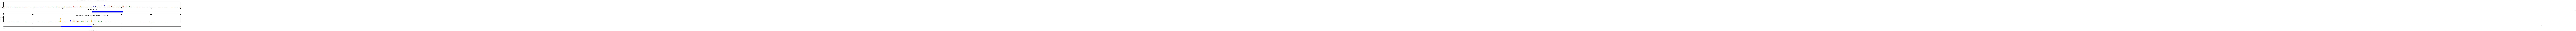

In [11]:
# Force reload
import sys
if 'splicevo.attributions.plot' in sys.modules:
    del sys.modules['splicevo.attributions.plot']
from splicevo.attributions.plot import plot_attributions_splice_from_result

# Plot
total_plots = len(result_splice['attributions'])
fig = plot_attributions_splice_from_result(
    result_splice, model_config, window=300, 
    gtf=gtf_paths, max_transcripts=1,
    ylim=(0, 0.5), figsize=(40, total_plots * 3)
)

In [10]:
%matplotlib inline
fig.savefig(f'plots/attributions_splice.pdf')
fig.show()

Next also compute usage attributions.

In [7]:
result_usage = compute_attributions_usage(
    model, sequences, labels, usage, metadata,
    window_indices=np.array([1919, 2224]),
    positions=[649, 610],
    condition_names=condition_names,
    device='cuda',
    verbose=False
)

for site_id, attr_data in result_usage['attributions'].items():
    print(f"Site {site_id}: type={attr_data['site_type']}")
    for cond, cond_name in enumerate(condition_names):
        if cond < 5:
            cond_attr = attr_data['attribution'][:,:,cond]
            print(f"  {cond}: {cond_name} total attribution={cond_attr.sum():.8f}")
    if cond >= 5:
        print(f"  ... and {len(condition_names) - 5} more conditions")

Site 1919_649: type=acceptor
  0: Brain_1 total attribution=-1.56019866
  1: Brain_10 total attribution=-1.19534576
  2: Brain_11 total attribution=-0.37557009
  3: Brain_12 total attribution=-0.25456285
  4: Brain_13 total attribution=-0.38428143
  ... and 94 more conditions
Site 2224_610: type=acceptor
  0: Brain_1 total attribution=-1.38305175
  1: Brain_10 total attribution=-1.20211983
  2: Brain_11 total attribution=-1.16657412
  3: Brain_12 total attribution=-0.80170131
  4: Brain_13 total attribution=-1.12067580
  ... and 94 more conditions


In [8]:
# Save usage attributions
save_usage = save_attributions_for_modisco(
    result_usage['attributions'], 
    output_path = f"{output_path}/usage",
    window=800,
    condition_names=condition_names,
    verbose=True)

Processing 1919_649
Inferred context 450
I will extract sequence and attributions range 699-1500
Sequence shape: (801, 4)
Processing 2224_610
Inferred context 450
I will extract sequence and attributions range 660-1461
Sequence shape: (801, 4)
Attributions shapes: (198, 801, 4)


In [9]:
import re

# Order conditions: Brain_1, Brain_2, ..., Brain_10, Heart_1, Heart_2, ..., Heart_10, etc.
def order_conditions_by_tissue_and_number(condition_names):
    def parse_name(name):
        # Split into tissue and number (e.g., 'Brain_10' -> ('Brain', 10))
        m = re.match(r"([A-Za-z]+)_(\d+)", name)
        if m:
            return (m.group(1), int(m.group(2)))
        else:
            return (name, 0)
    # Sort by tissue, then by number
    return sorted(range(len(condition_names)), key=lambda i: parse_name(condition_names[i]))

ordered_conditions = order_conditions_by_tissue_and_number(condition_names)

for i in ordered_conditions:
    print(f"{i}: {condition_names[i]}")

0: Brain_1
6: Brain_2
7: Brain_3
8: Brain_4
9: Brain_5
10: Brain_6
11: Brain_7
12: Brain_8
13: Brain_9
1: Brain_10
2: Brain_11
3: Brain_12
4: Brain_13
5: Brain_14
20: Cerebellum_2
21: Cerebellum_3
22: Cerebellum_4
23: Cerebellum_5
24: Cerebellum_6
25: Cerebellum_7
26: Cerebellum_8
27: Cerebellum_9
14: Cerebellum_10
15: Cerebellum_11
16: Cerebellum_12
17: Cerebellum_13
18: Cerebellum_14
19: Cerebellum_15
28: Heart_1
34: Heart_2
35: Heart_3
36: Heart_4
37: Heart_5
38: Heart_6
39: Heart_7
40: Heart_8
41: Heart_9
29: Heart_10
30: Heart_11
31: Heart_12
32: Heart_13
33: Heart_14
47: Kidney_2
48: Kidney_3
49: Kidney_4
50: Kidney_5
51: Kidney_6
52: Kidney_7
53: Kidney_8
54: Kidney_9
42: Kidney_10
43: Kidney_11
44: Kidney_12
45: Kidney_13
46: Kidney_14
55: Liver_1
62: Liver_2
63: Liver_3
64: Liver_4
65: Liver_5
66: Liver_6
67: Liver_7
68: Liver_8
69: Liver_9
56: Liver_10
57: Liver_11
58: Liver_12
59: Liver_13
60: Liver_14
61: Liver_15
70: Ovary_1
76: Ovary_2
77: Ovary_3
78: Ovary_4
79: Ovary_5


In [10]:
import re
import sys

# Force reload of modules
if 'splicevo' in sys.modules:
    to_remove = [k for k in sys.modules if k.startswith('splicevo')]
    for k in to_remove:
        del sys.modules[k]

# Reimport
from splicevo.attributions.plot import plot_attributions_usage_from_result

for site_id in result_usage['attributions'].keys():

    print(site_id)

    for tissue in ['Brain', 'Cerebellum', 'Kidney', 'Liver', 'Ovary', 'Testis']:

        # Get conditions to plot
        condition_id = []
        for i in ordered_conditions:
            m = re.match(r"([A-Za-z]+)_(\d+)", condition_names[i])
            if m.group(1) == tissue:
                condition_id.append(i)

        # Calculate figure size
        total_plots = len(condition_id)
        
        # Plot
        fig = plot_attributions_usage_from_result(
            result_usage, model_config,
            conditions=condition_names,
            conditions_to_plot=condition_id,
            sites_to_plot=site_id,
            window=600,
            ylim='auto',
            gtf=gtf_paths, max_transcripts=5,
            figsize = (25, max(6, min(1.5 * total_plots, 1.5 * 50)))
        )
        fig.savefig(f'plots/attributions_{site_id}_{tissue}.pdf', dpi=300, bbox_inches='tight')
        plt.close(fig)

1919_649
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Hom

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 442654 GTF records
Extracting transcripts...
Processing 406999 exon records from 35655 transcripts...
Created 35655 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


2224_610
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Hom

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 266249 GTF records
Extracting transcripts...
Processing 242854 exon records from 23395 transcripts...
Created 23395 transcript objects
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens

/sasselab3/home/elek/projects/splicevo/src/splicevo/attributions/plot.py:712: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
